# AI Model for Predicting Sea Surface Currents 

This notebook outlines the steps to develop a CNN-LSTM hybrid model for predicting future sea surface currents.

### Importing necessary libraries

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, 
    BatchNormalization, Reshape)
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tqdm.keras import TqdmCallback
import pickle

### Printing info about Sea Surace Currents Dataset

In [2]:
# Load the processed sea surface current (SSC) data
ssc_data_path = "Data/Processed_SSC_Data-Copy1.nc"
ssc_ds = xr.open_dataset(ssc_data_path)

# Display the dataset structure
print(ssc_ds)
print("="*125)

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 22, time: 2091)
Coordinates:
  * lat      (lat) float32 35.74 35.77 35.79 35.81 ... 36.21 36.23 36.26 36.28
  * lon      (lon) float32 13.92 13.96 14.0 14.04 ... 14.65 14.69 14.73 14.77
  * time     (time) datetime64[ns] 2021-01-01 2021-01-01T12:00:00 ... 2023-11-12
Data variables:
    u        (time, lat, lon) float64 ...
    v        (time, lat, lon) float64 ...
    stdu     (time, lat, lon) float64 ...
    stdv     (time, lat, lon) float64 ...
    cov      (time, lat, lon) float64 ...
    velo     (time, lat, lon) float64 ...
    head     (time, lat, lon) float64 ...
Attributes: (12/17)
    NC_GLOBAL.Title:                   Near-Real time Surface Ocean Velocity
    NC_GLOBAL.origin:                  BARK (measured);POZZ (measured);
    NC_GLOBAL.source:                  HF Radar Derived Surface Currents obta...
    NC_GLOBAL.history:                 08-Jun-2023 14:46:23
    NC_GLOBAL.grid_type:               REGULAR
    NC_GLOBAL.Convent

### Data Preparation 

In [3]:
# Selecting only the 'u' and 'v' variables
uv_ds = ssc_ds[['u', 'v']]

uv_ds = uv_ds.fillna(uv_ds.mean())

# Standardize the 'u' and 'v' variables
uv_mean = uv_ds.mean(dim=['time', 'lat', 'lon'])
uv_std = uv_ds.std(dim=['time', 'lat', 'lon'])

uv_standardized = (uv_ds - uv_mean) / uv_std

def create_sequences(data, sequence_length=28):
    """
    Creates sequences of data for training.
    :param data: The standardized dataset containing 'u' and 'v'.
    :param sequence_length: The number of time steps to use for each sequence.
    :return: X, y where X is a sequence of data and y is the label for each sequence.
    """
    X = []
    y = []

    # Convert data to a Dataset to an array for easier slicing
    data_array = data.to_array().transpose("time", "lat", "lon", "variable")
    print(f"Data array shape after transpose: {data_array.shape}")

    for i in range(len(data.time) - sequence_length):
        X_seq = data_array.isel(time=slice(i, i + sequence_length)).values
        y_seq = data_array.isel(time=i + sequence_length).values
        
        X.append(X_seq)
        y.append(y_seq)

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # No need to move axes, as we already transposed data to the correct shape
    return X, y

# Prepare the data for sequence creation
X, y = create_sequences(uv_standardized)

# Information about the shapes of X and y for confirmation
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Check if there are NaNs in the standardized data
assert not np.isnan(uv_standardized.to_array()).any(), "There are NaNs in the standardized data"

Data array shape after transpose: (2091, 25, 22, 2)
Shape of X: (2063, 28, 25, 22, 2)
Shape of y: (2063, 25, 22, 2)


### Model Definition

In [4]:
# Model configuration
input_shape = (28, 25, 22, 2)
conv_filters = 16  
kernel_size = (3, 3)
pool_size = (2, 2)
lstm_units = 64  
dense_units = 50  
output_shape = 25 * 22 * 2

# Define the model with added complexity
model = Sequential([
    TimeDistributed(Conv2D(conv_filters, kernel_size, padding='same', activation='relu', 
                           kernel_regularizer=l1_l2(l1=0.01, l2=0.01)), input_shape=input_shape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=pool_size)),
    TimeDistributed(Conv2D(conv_filters * 2, kernel_size, padding='same', activation='relu', 
                           kernel_regularizer=l1_l2(l1=0.01, l2=0.01))),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=pool_size)),
    TimeDistributed(Flatten()),
    LSTM(lstm_units, activation='tanh', return_sequences=True),  
    LSTM(lstm_units, activation='tanh', return_sequences=False), 
    Dropout(0.5),
    Dense(dense_units, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    Dropout(0.5),
    Dense(output_shape),
    Reshape((25, 22, 2))
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 28, 25, 22, 16)   304       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 28, 25, 22, 16)   64        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 28, 12, 11, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 28, 12, 11, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 28, 12, 11, 32)   1

### Compile the Model

In [5]:
optimizer = Adam(learning_rate=0.001, clipvalue=1.0)
model.compile(optimizer=optimizer, loss='mse')

### Train the Model

In [6]:
# Define the split indices
train_split_idx = int(0.7 * len(X))  # 70% for training
val_split_idx = train_split_idx + int(0.15 * len(X))  # Additional 15% for validation

# Split the dataset
X_train, X_val, X_test = X[:train_split_idx], X[train_split_idx:val_split_idx], X[val_split_idx:]
y_train, y_val, y_test = y[:train_split_idx], y[train_split_idx:val_split_idx], y[val_split_idx:]

# Training configuration
epochs = 1000
batch_size = 16

# Custom callback for detailed epoch output
class DetailedEpochCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss')
        train_loss = logs.get('loss')
        print(f"\nEpoch {epoch + 1}: Training Loss: {train_loss:.5f}, Validation Loss: {val_loss:.5f}")
        print("=" * 125)

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,  
    verbose=1,  
    restore_best_weights=True  
)

# ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,  
    patience=10,  
    verbose=1,
    mode='min',  
    min_delta=1e-5,
    cooldown=0,  
    min_lr=0.00001  
)

# Custom callback along with TqdmCallback and EarlyStopping
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    verbose=0,  
    callbacks=[
        TqdmCallback(verbose=1),  
        DetailedEpochCallback(),  
        early_stopping,
        reduce_lr   
    ]
)

# Save the history to a file
with open('Model_Outputs/SSC_Model_History.pkl', 'wb') as f:
    pickle.dump(history.history, f)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Epoch 1: Training Loss: 5.31269, Validation Loss: 2.51328

Epoch 2: Training Loss: 1.91964, Validation Loss: 1.02678

Epoch 3: Training Loss: 1.11453, Validation Loss: 0.72684

Epoch 4: Training Loss: 1.01441, Validation Loss: 0.71508

Epoch 5: Training Loss: 1.00198, Validation Loss: 0.69823

Epoch 6: Training Loss: 0.97828, Validation Loss: 0.67968

Epoch 7: Training Loss: 0.97255, Validation Loss: 0.66649

Epoch 8: Training Loss: 0.96404, Validation Loss: 0.65806

Epoch 9: Training Loss: 0.96304, Validation Loss: 0.65371

Epoch 10: Training Loss: 0.94047, Validation Loss: 0.64849

Epoch 11: Training Loss: 0.94350, Validation Loss: 0.65935

Epoch 12: Training Loss: 0.93606, Validation Loss: 0.67940

Epoch 13: Training Loss: 0.93287, Validation Loss: 0.67729

Epoch 14: Training Loss: 0.93196, Validation Loss: 0.65978

Epoch 15: Training Loss: 0.92044, Validation Loss: 0.65465

Epoch 16: Training Loss: 0.90800, Validation Loss: 0.64072

Epoch 17: Training Loss: 0.91141, Validation Los

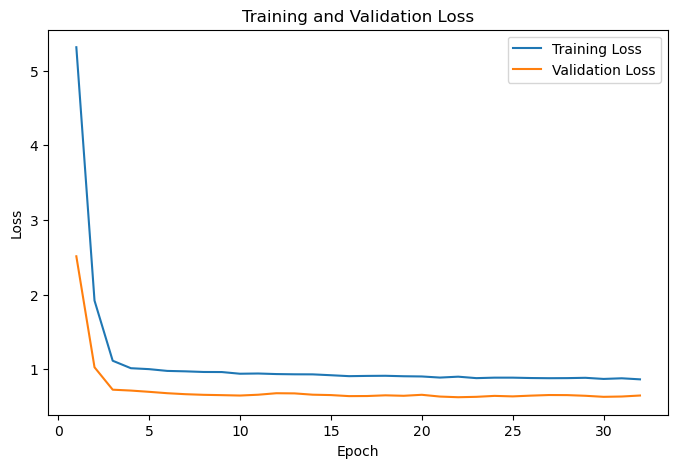

In [7]:
  # Load the history from a file
with open('Model_Outputs/SSC_Model_History.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

# Extracting the loss values for plotting
train_loss = loaded_history['loss']
val_loss = loaded_history['val_loss']
epochs_range = range(1, len(train_loss) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Model Evaluation

After training our Convolutional Neural Network-Long Short Term Memory (CNN-LSTM) model, it is essential to assess its performance to understand how well it has learned from the training dataset and to evaluate its ability to generalize to unseen data. This step involves calculating loss and accuracy metrics on both the validation and test datasets.

### Validation Set Evaluation

In [8]:
# Evaluate the model on the validation set
val_loss = model.evaluate(X_val, y_val, verbose=0)
val_predictions = model.predict(X_val, verbose=0)

# Calculate error metrics for the validation set
val_mae = mean_absolute_error(y_val.reshape(-1, y_val.shape[-1]), val_predictions.reshape(-1, val_predictions.shape[-1]))
val_mse = mean_squared_error(y_val.reshape(-1, y_val.shape[-1]), val_predictions.reshape(-1, val_predictions.shape[-1]))
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val.reshape(-1, y_val.shape[-1]), val_predictions.reshape(-1, val_predictions.shape[-1]))

print(f"Validation Loss (MSE): {val_loss:.4f}")
print(f"Validation MAE: {val_mae:.4f}")
print(f"Validation MSE: {val_mse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation R^2: {val_r2:.4f}\n")

Validation Loss (MSE): 0.6259
Validation MAE: 0.2821
Validation MSE: 0.5246
Validation RMSE: 0.7243
Validation R^2: 0.1838



### Test Set Evaluation

In [9]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=0)
test_predictions = model.predict(X_test, verbose=0)

# Calculate error metrics for the test set
test_mae = mean_absolute_error(y_test.reshape(-1, y_test.shape[-1]), test_predictions.reshape(-1, test_predictions.shape[-1]))
test_mse = mean_squared_error(y_test.reshape(-1, y_test.shape[-1]), test_predictions.reshape(-1, test_predictions.shape[-1]))
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test.reshape(-1, y_test.shape[-1]), test_predictions.reshape(-1, test_predictions.shape[-1]))

print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R^2: {test_r2:.4f}\n")

Test Loss (MSE): 0.8304
Test MAE: 0.3904
Test MSE: 0.7290
Test RMSE: 0.8538
Test R^2: 0.2816



### Visualizing Predictions

Plots for Validation Set:


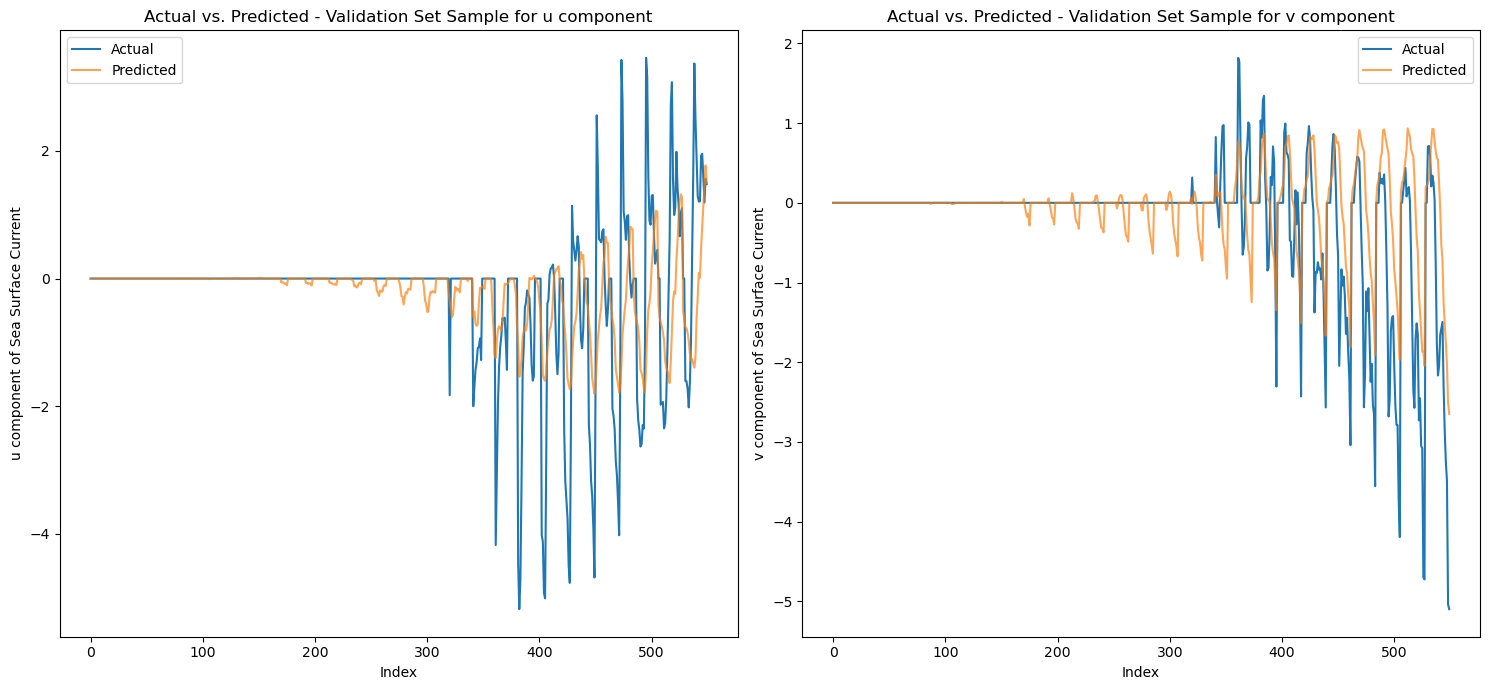

Plots for Test Set:


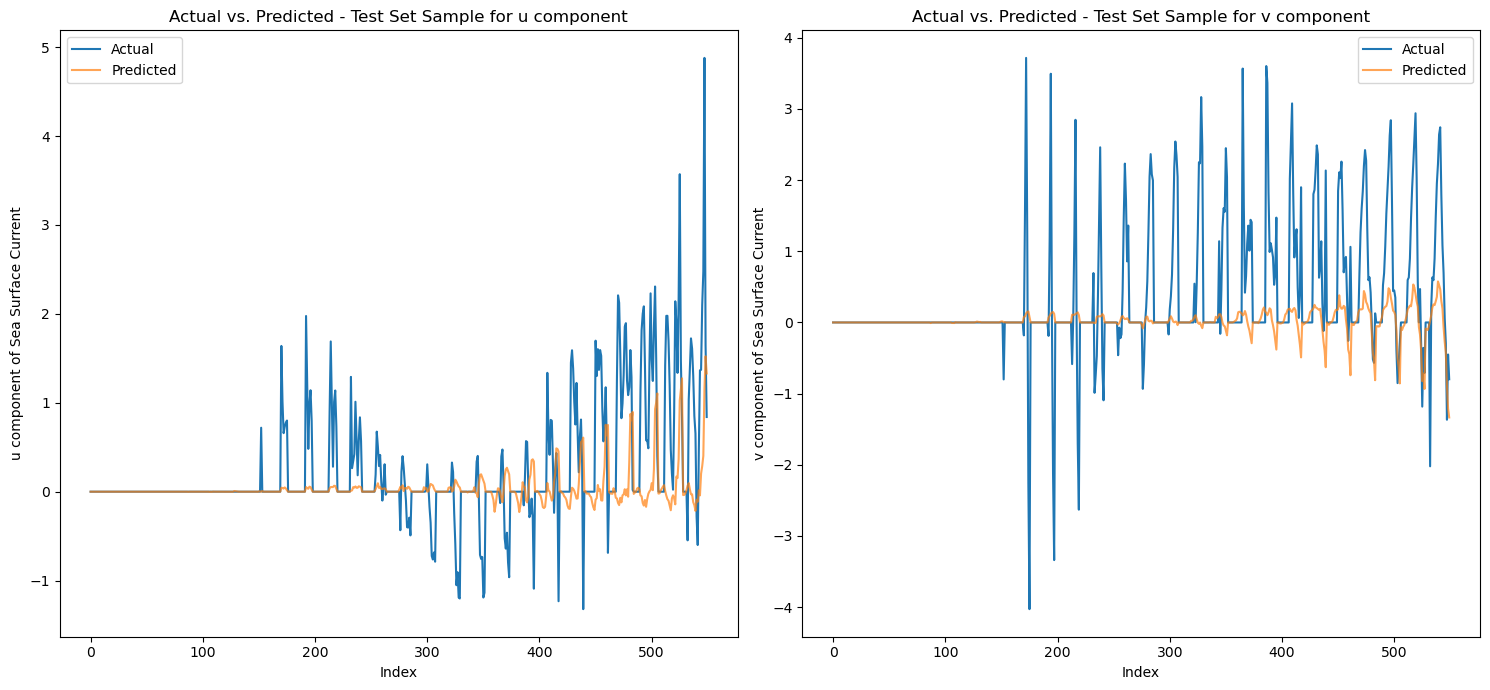

In [10]:
print("Plots for Validation Set:")

# Example: Visualizing the Actual vs. Predicted 'u' and 'v' components for the first sample in the validation set
plt.figure(figsize=(15, 7))

# Plot 'u' component
plt.subplot(1, 2, 1)
plt.plot(y_val[0, :, :, 0].flatten(), label='Actual')
plt.plot(val_predictions[0, :, :, 0].flatten(), label='Predicted', alpha=0.7)
plt.title('Actual vs. Predicted - Validation Set Sample for u component')
plt.xlabel('Index')
plt.ylabel('u component of Sea Surface Current')
plt.legend()

# Plot 'v' component
plt.subplot(1, 2, 2)
plt.plot(y_val[0, :, :, 1].flatten(), label='Actual')
plt.plot(val_predictions[0, :, :, 1].flatten(), label='Predicted', alpha=0.7)
plt.title('Actual vs. Predicted - Validation Set Sample for v component')
plt.xlabel('Index')
plt.ylabel('v component of Sea Surface Current')
plt.legend()

plt.tight_layout()
plt.show()

print("="*125)
print("Plots for Test Set:")

# Example: Visualizing the Actual vs. Predicted 'u' component for the first sample in the test set
plt.figure(figsize=(15, 7))

# Plot 'u' component
plt.subplot(1, 2, 1)
plt.plot(y_test[0, :, :, 0].flatten(), label='Actual')
plt.plot(test_predictions[0, :, :, 0].flatten(), label='Predicted', alpha=0.7)
plt.title('Actual vs. Predicted - Test Set Sample for u component')
plt.xlabel('Index')
plt.ylabel('u component of Sea Surface Current')
plt.legend()

# Plot 'v' component
plt.subplot(1, 2, 2)
plt.plot(y_test[0, :, :, 1].flatten(), label='Actual')
plt.plot(test_predictions[0, :, :, 1].flatten(), label='Predicted', alpha=0.7)
plt.title('Actual vs. Predicted - Test Set Sample for v component')
plt.xlabel('Index')
plt.ylabel('v component of Sea Surface Current')
plt.legend()

plt.tight_layout()
plt.show()

print("="*125)

### Exporting Predictions

In [11]:
# Use the last sequence from the test set as the starting point for rolling predictions
# The last sequence consists of 28 time steps, each representing 12 hours, amounting to the last 14 days of data.
# The model will make a prediction for the next 12 hours based on this sequence.
# After each prediction, the sequence is updated: it is rolled to discard the oldest time step,
# and the latest prediction is appended, maintaining a sequence length of 28 time steps.
# This process is repeated to predict sea surface currents for the next 28 days.
X_initial = X_test[-1]

# Collect predictions in a list
predictions = []

for step in range(56):  # 28 days * 2 predictions per day
    # Make a prediction for the next 12 hours
    next_prediction = model.predict(X_initial.reshape(1, 28, 25, 22, 2), verbose=0)
    
    # Store the prediction
    predictions.append(next_prediction[0])  # next_prediction[0] to get the single prediction from batch
    
    # Update the current sequence with the new prediction
    X_initial = np.roll(X_initial, -1, axis=0)
    X_initial[-1] = next_prediction[0]  # Update with the predicted values for the next time step

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Extract coordinates from the original dataset
time_data = ssc_ds.coords['time'][-len(predictions):].values
lat_data = ssc_ds.coords['lat'].values
lon_data = ssc_ds.coords['lon'].values

# Create a new xarray Dataset
predicted_dataset = xr.Dataset(
    {
        "u": (["time", "lat", "lon"], predictions[:, :, :, 0]),
        "v": (["time", "lat", "lon"], predictions[:, :, :, 1])
    },
    coords={
        "time": time_data,  
        "lat": lat_data,    
        "lon": lon_data     
    }
)

# Export to NetCDF
predicted_dataset.to_netcdf("Model_Outputs/predicted_ssc_data.nc")

### Simulating real life example

MAE: 0.3596
MSE: 0.5630
RMSE: 0.7503
R^2: 0.2893



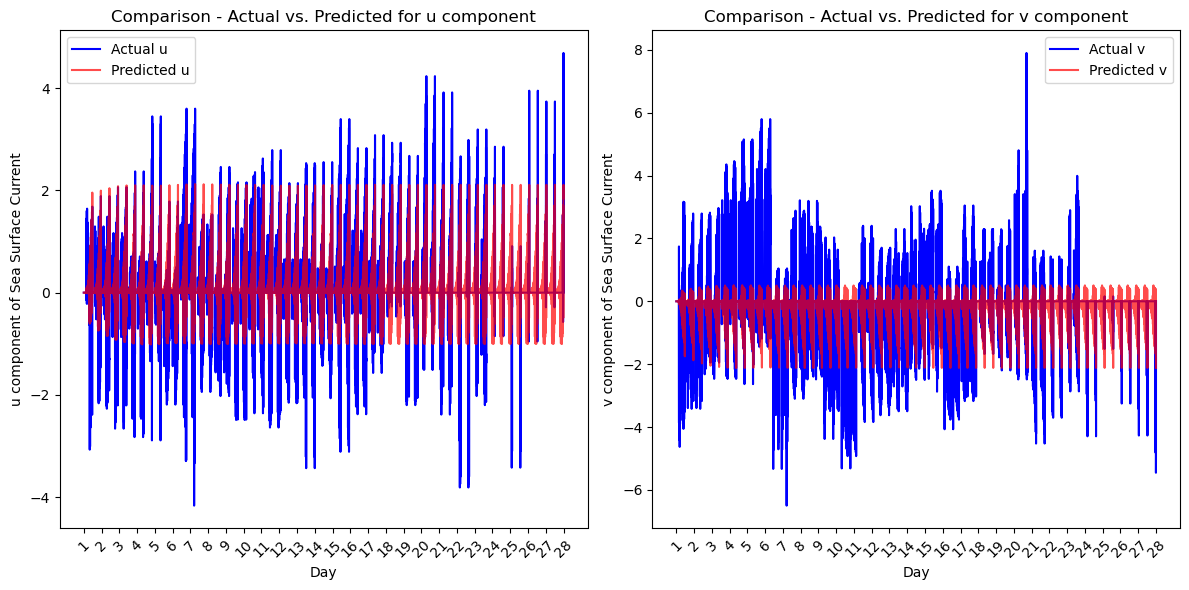

In [12]:
# Start from the second to last sequence for 28-day forecasting
X_initial = X_test[-2]  # This is the correct starting point for the forecast

# Initialize an array to collect predictions
predictions = []

# Generate predictions for the next 28 days, with each step forecasting the next 12-hour period
for step in range(56):  # 28 days * 2 predictions per day
    next_prediction = model.predict(X_initial.reshape(1, 28, 25, 22, 2), verbose=0)
    predictions.append(next_prediction[0])
    # Update the sequence with the new prediction
    X_initial = np.roll(X_initial, -1, axis=0)
    X_initial[-1] = next_prediction[0]

predictions = np.array(predictions)

actual_data = y_test[-56:]  # This selects the last 56 time points, which correspond to the next 28 days

# Calculate error metrics for comparison
forecast_error_metrics = mean_absolute_error(actual_data.reshape(-1, actual_data.shape[-1]), predictions.reshape(-1, predictions.shape[-1]))
mse = mean_squared_error(actual_data.reshape(-1, actual_data.shape[-1]), predictions.reshape(-1, predictions.shape[-1]))
rmse = np.sqrt(mse)
r2 = r2_score(actual_data.reshape(-1, actual_data.shape[-1]), predictions.reshape(-1, predictions.shape[-1]))

print(f"MAE: {forecast_error_metrics:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}\n")

# Visualization for comparison
plt.figure(figsize=(12, 6))

# Comparing the 'u' component
plt.subplot(1, 2, 1)
plt.plot(actual_data[:, :, :, 0].reshape(-1), label='Actual u', color='blue')
plt.plot(predictions[:, :, :, 0].reshape(-1), label='Predicted u', color='red', alpha=0.7)
plt.title('Comparison - Actual vs. Predicted for u component')
plt.xlabel('Day')
plt.ylabel('u component of Sea Surface Current')

# Create a list of day labels, one for each day in the prediction period
day_labels = [f'{i+1}' for i in range(28)]
# Set the tick locations and labels
plt.xticks(ticks=np.linspace(0, len(predictions[:, :, :, 0].reshape(-1))-1, 28), labels=day_labels, rotation=45)
plt.legend()

# Comparing the 'v' component
plt.subplot(1, 2, 2)
plt.plot(actual_data[:, :, :, 1].reshape(-1), label='Actual v', color='blue')
plt.plot(predictions[:, :, :, 1].reshape(-1), label='Predicted v', color='red', alpha=0.7)
plt.title('Comparison - Actual vs. Predicted for v component')
plt.xlabel('Day')
plt.ylabel('v component of Sea Surface Current')

# Set the tick locations and labels
plt.xticks(ticks=np.linspace(0, len(predictions[:, :, :, 1].reshape(-1))-1, 28), labels=day_labels, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()